In [27]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import networkx as nx
import matplotlib.pyplot as plt
sb.set()

In [28]:
df = pd.read_csv("SFlow_Data_1.csv", index_col=False, names=["Type", "AgentIPAddress", "inputPort", "outputPort", "src_MAC", "dst_MAC", "ethernet_type", "in_vlan", "out_vlan", "src_IP", "dst_IP", "IP_protocol", "ip_tos", "ip_ttl", "udp_src_port OR tcp_src_port OR icmp_type", "udp_dst_port OR tcp_dst_port OR icmp_code", "tcp_flags", "packet_size", "IP_size", "sampling_rate"])

/var/folders/lb/hsgx9s3s1sb282vw9s4gnrvr0000gn/T/ipykernel_64677/957855310.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv("SFlow_Data_1.csv", index_col=False, names=["Type", "AgentIPAddress", "inputPort", "outputPort", "src_MAC", "dst_MAC", "ethernet_type", "in_vlan", "out_vlan", "src_IP", "dst_IP", "IP_protocol", "ip_tos", "ip_ttl", "udp_src_port OR tcp_src_port OR icmp_type", "udp_dst_port OR tcp_dst_port OR icmp_code", "tcp_flags", "packet_size", "IP_size", "sampling_rate"])


In [29]:
#Importing and Reading Data
print('Number of Rows:', len(df))
print('Number of missing/NULL values:', df.isnull().values.any())
df.head(5)


Number of Rows: 69370
Number of missing/NULL values: False


Type AgentIPAddress  inputPort  outputPort       src_MAC       dst_MAC  \
0  FLOW    aa.aa.aa.aa        137         200  d404ff55fd4d  80711fc76001   
1  FLOW    aa.aa.aa.aa        129         193  609c9f851b00  0031466b23cf   
2  FLOW    aa.aa.aa.aa        137         200  d404ff55fd4d  80711fc76001   
3  FLOW    aa.aa.aa.aa        129         135  609c9f851b00  002688cd5fc7   
4  FLOW    aa.aa.aa.aa        130         199  00239cd087c1  544b8cf9a7df   

  ethernet_type  in_vlan  out_vlan          src_IP          dst_IP  \
0        0x0800    919.0       280  130.246.176.22   140.115.32.81   
1        0x0800     11.0       919   155.69.160.32  64.233.188.128   
2        0x0800    919.0       280  130.246.176.53   140.115.32.83   
3        0x0800     11.0       919   155.69.160.32   54.169.174.79   
4        0x0800    919.0       600  137.132.228.15    193.62.192.8   

   IP_protocol ip_tos  ip_ttl  udp_src_port OR tcp_src_port OR icmp_type  \
0            6   0x00      50                                    51216.0   
1            6   0x00      56                                    23159.0   
2            6   0x00      50                                    50041.0   
3           17   0x00     120                                    54241.0   
4            6   0x00      56                                    53923.0   

   udp_dst_port OR tcp_dst_port OR icmp_code tcp_flags  packet_size  IP_size  \
0                                      23505      0x10         1518     1500   
1                                         80      0x10           74       52   
2                                      20739      0x10         1518     1500   
3                                      26510      0x10          116       94   
4                                      34262      0x10           70       52   

   sampling_rate  
0           2048  
1           2048  
2           2048  
3           2048  
4           2048

## EXERCISE 4A: TOP TALKERS AND LISTENERS


For this task, I will be counting the source IP address that appears most frequently

In [30]:
srcDF = df.src_IP.value_counts().head(5)
srcDF


193.62.192.8     3041
155.69.160.32    2975
130.14.250.11    2604
14.139.196.58    2452
140.112.8.139    2056
Name: src_IP, dtype: int64

In [31]:
dstDF = df.dst_IP.value_counts(ascending=False).head(5)
dstDF

103.37.198.100     3841
137.132.228.15     3715
202.21.159.244     2446
192.101.107.153    2368
103.21.126.2       2056
Name: dst_IP, dtype: int64

## EXERCISE 4B: TRANSPORT PROTOCOL
Using the IP protocol type attribute, determine the percentage of TCP and UDP protocol

In [32]:
appDF = df['udp_dst_port OR tcp_dst_port OR icmp_code'].value_counts().head(5)
appDF

443      13423
80        2647
52866     2068
45512     1356
56152     1341
Name: udp_dst_port OR tcp_dst_port OR icmp_code, dtype: int64

In [33]:
dict_transport_protocol = {0:"HOPOPT", 1:"ICMP", 2:"IGMP", 6:"TCP", 17:"UDP", 
                           41:"IPv6", 47:"GRE", 50:"ESP", 58:" IPv6-ICMP"}
ip_protocol = df.loc[:,"IP_protocol"].copy()


In [34]:
protocoldict = {6:"TCP", 17:"UDP"}

ip_protocol = df.loc[:,"IP_protocol"].copy()
summ = ip_protocol.value_counts(dropna=False)
percentage = ip_protocol.value_counts(dropna=False,normalize=True).mul(100)
ip_freq = pd.concat([summ, percentage], axis = 1, keys=['# of packets', '%']).reset_index()
ip_freq.set_axis(['Header value', '# of packets', '%'], axis = 'columns', inplace = True)
maplist = ip_freq['Header value'].map(lambda x: protocoldict.get(x, 'Others'))

ip_freq.insert(1, "Protocol", maplist)
ip_freq = ip_freq.groupby('Protocol', as_index=False).agg({'# of packets':sum, '%': sum}).sort_values(by='# of packets', ascending=False)
tlist = ['6', '17', '_']
ip_freq.insert(0, 'Header value', tlist)
ip_freq
#ip_freq2 = ip_freq.groupby('Protocol')['# of packets'].sum().reset_index()
#ip_freq2
#typelist = ip_freq[]


Header value Protocol  # of packets          %
1            6      TCP         56064  80.818798
2           17      UDP          9462  13.639902
0            _   Others          3844   5.541300

## EXERCISE 4C: APPLICATIONS PROTOCOL
Using the Destination IP port number determine the TOP 5 most frequently used application protocol.

In [35]:
protocol_dict = {443:'HTTPS (http protocol over TLS/SSL)', 80:'HTTP (World Wide Web HTTP)', 
                             50930:'Dynamic and/or Private Ports OR Hypack Data Aquisition', 
                             15000:'Dynamic and/or Private Ports OR Xsan Filesystem Access',
                             8160:'Patrol'}

application_protocol = df.loc[:,'udp_dst_port OR tcp_dst_port OR icmp_code'].copy()
summm = application_protocol.value_counts(dropna=False)
application_freq = pd.concat([summm], axis=1, keys=['# of packets']).head(5)
application_freq.index.name = 'Destination IP port number'
application_freq = application_freq.reset_index()
#servicelist = application_protocol
application_freq['Service'] = application_freq['Destination IP port number'].map(protocol_dict)
application_freq


Destination IP port number  # of packets  \
0                         443         13423   
1                          80          2647   
2                       52866          2068   
3                       45512          1356   
4                       56152          1341   

                              Service  
0  HTTPS (http protocol over TLS/SSL)  
1          HTTP (World Wide Web HTTP)  
2                                 NaN  
3                                 NaN  
4                                 NaN

## EXERCISE 4D: TRAFFIC INTENSITY
The traffic intensity is an important parameter that a network engineer needs to monitor closely to determine if there is congestion. You would use the IP packet size to calculate the estimated total traffic over the monitored period of 15 seconds. (Assume the sampling rate is 1 in 2048)

In [36]:
#Get IP Size
IP_size = df[['IP_size']]
total_traffic = IP_size['IP_size'].sum()

print('SFlow Size (Bytes):', total_traffic)
print('Total sampled traffic (based on 1MB = 1024^2 B):', total_traffic/1024/1024, 'MB')
print('Total sampled traffic (based on 1MB = 1000^2 B):', total_traffic/1000/1000, 'MB')
#Assume the sampling rate is 1 in 2048
print()
print('NetFlow Size (Bytes):', total_traffic*2048)
print('Estimated total traffic (based on 1MB = 1024^2 B):', total_traffic*2048/1024/1024, 'MB')
print('Estimated total traffic (based on 1MB = 1000^2 B):', total_traffic*2048/1000/1000, 'MB')

SFlow Size (Bytes): 64777822
Total sampled traffic (based on 1MB = 1024^2 B): 61.77694511413574 MB
Total sampled traffic (based on 1MB = 1000^2 B): 64.777822 MB

NetFlow Size (Bytes): 132664979456
Estimated total traffic (based on 1MB = 1024^2 B): 126519.18359375 MB
Estimated total traffic (based on 1MB = 1000^2 B): 132664.979456 MB


## EXERCISE 4E: ADDITIONAL ANALYSIS
Please described additional analysis of the data and how it is useful. Please use a separate sheet to submit your new graphs and observations. Your report for this exercise is limited to 2 pages. The answer template and the two page additional analysis are to be submitted to your e-learning drive.

### Top 5 Communication Pair


In [37]:
#Get Dataframe and Initialise List to store pairs
src_dst_df = df[['src_IP','dst_IP']]
ip_pair_list = []

#Iterate through df and store pairs (sorted to ensure no mix between src and dst)
for index,row in src_dst_df.iterrows():
    pair = [row['src_IP'], row['dst_IP']]
    pair.sort()
    ip_pair_list.append(pair)

#Create new DataFrame and get count. Reformat with header
ip_pairs = pd.DataFrame(ip_pair_list,columns=['IP Address 1', 'IP Address 2'])
ip_pairs = ip_pairs.pivot_table(index=['IP Address 1', 'IP Address 2'], aggfunc='size')
top_5_ip_pairs = ip_pairs.sort_values(ascending=False).head(5).to_frame()
top_5_ip_pairs.columns = ['# Number of Communications']
top_5_ip_pairs = top_5_ip_pairs.reset_index()

top_5_ip_pairs

IP Address 1     IP Address 2  # Number of Communications
0  137.132.228.15     193.62.192.8                        4951
1  103.37.198.100    130.14.250.11                        2842
2   14.139.196.58  192.101.107.153                        2368
3    103.21.126.2    140.112.8.139                        2056
4   140.90.101.61     167.205.52.8                        1752

### Visualizing the communication between different IP hosts.

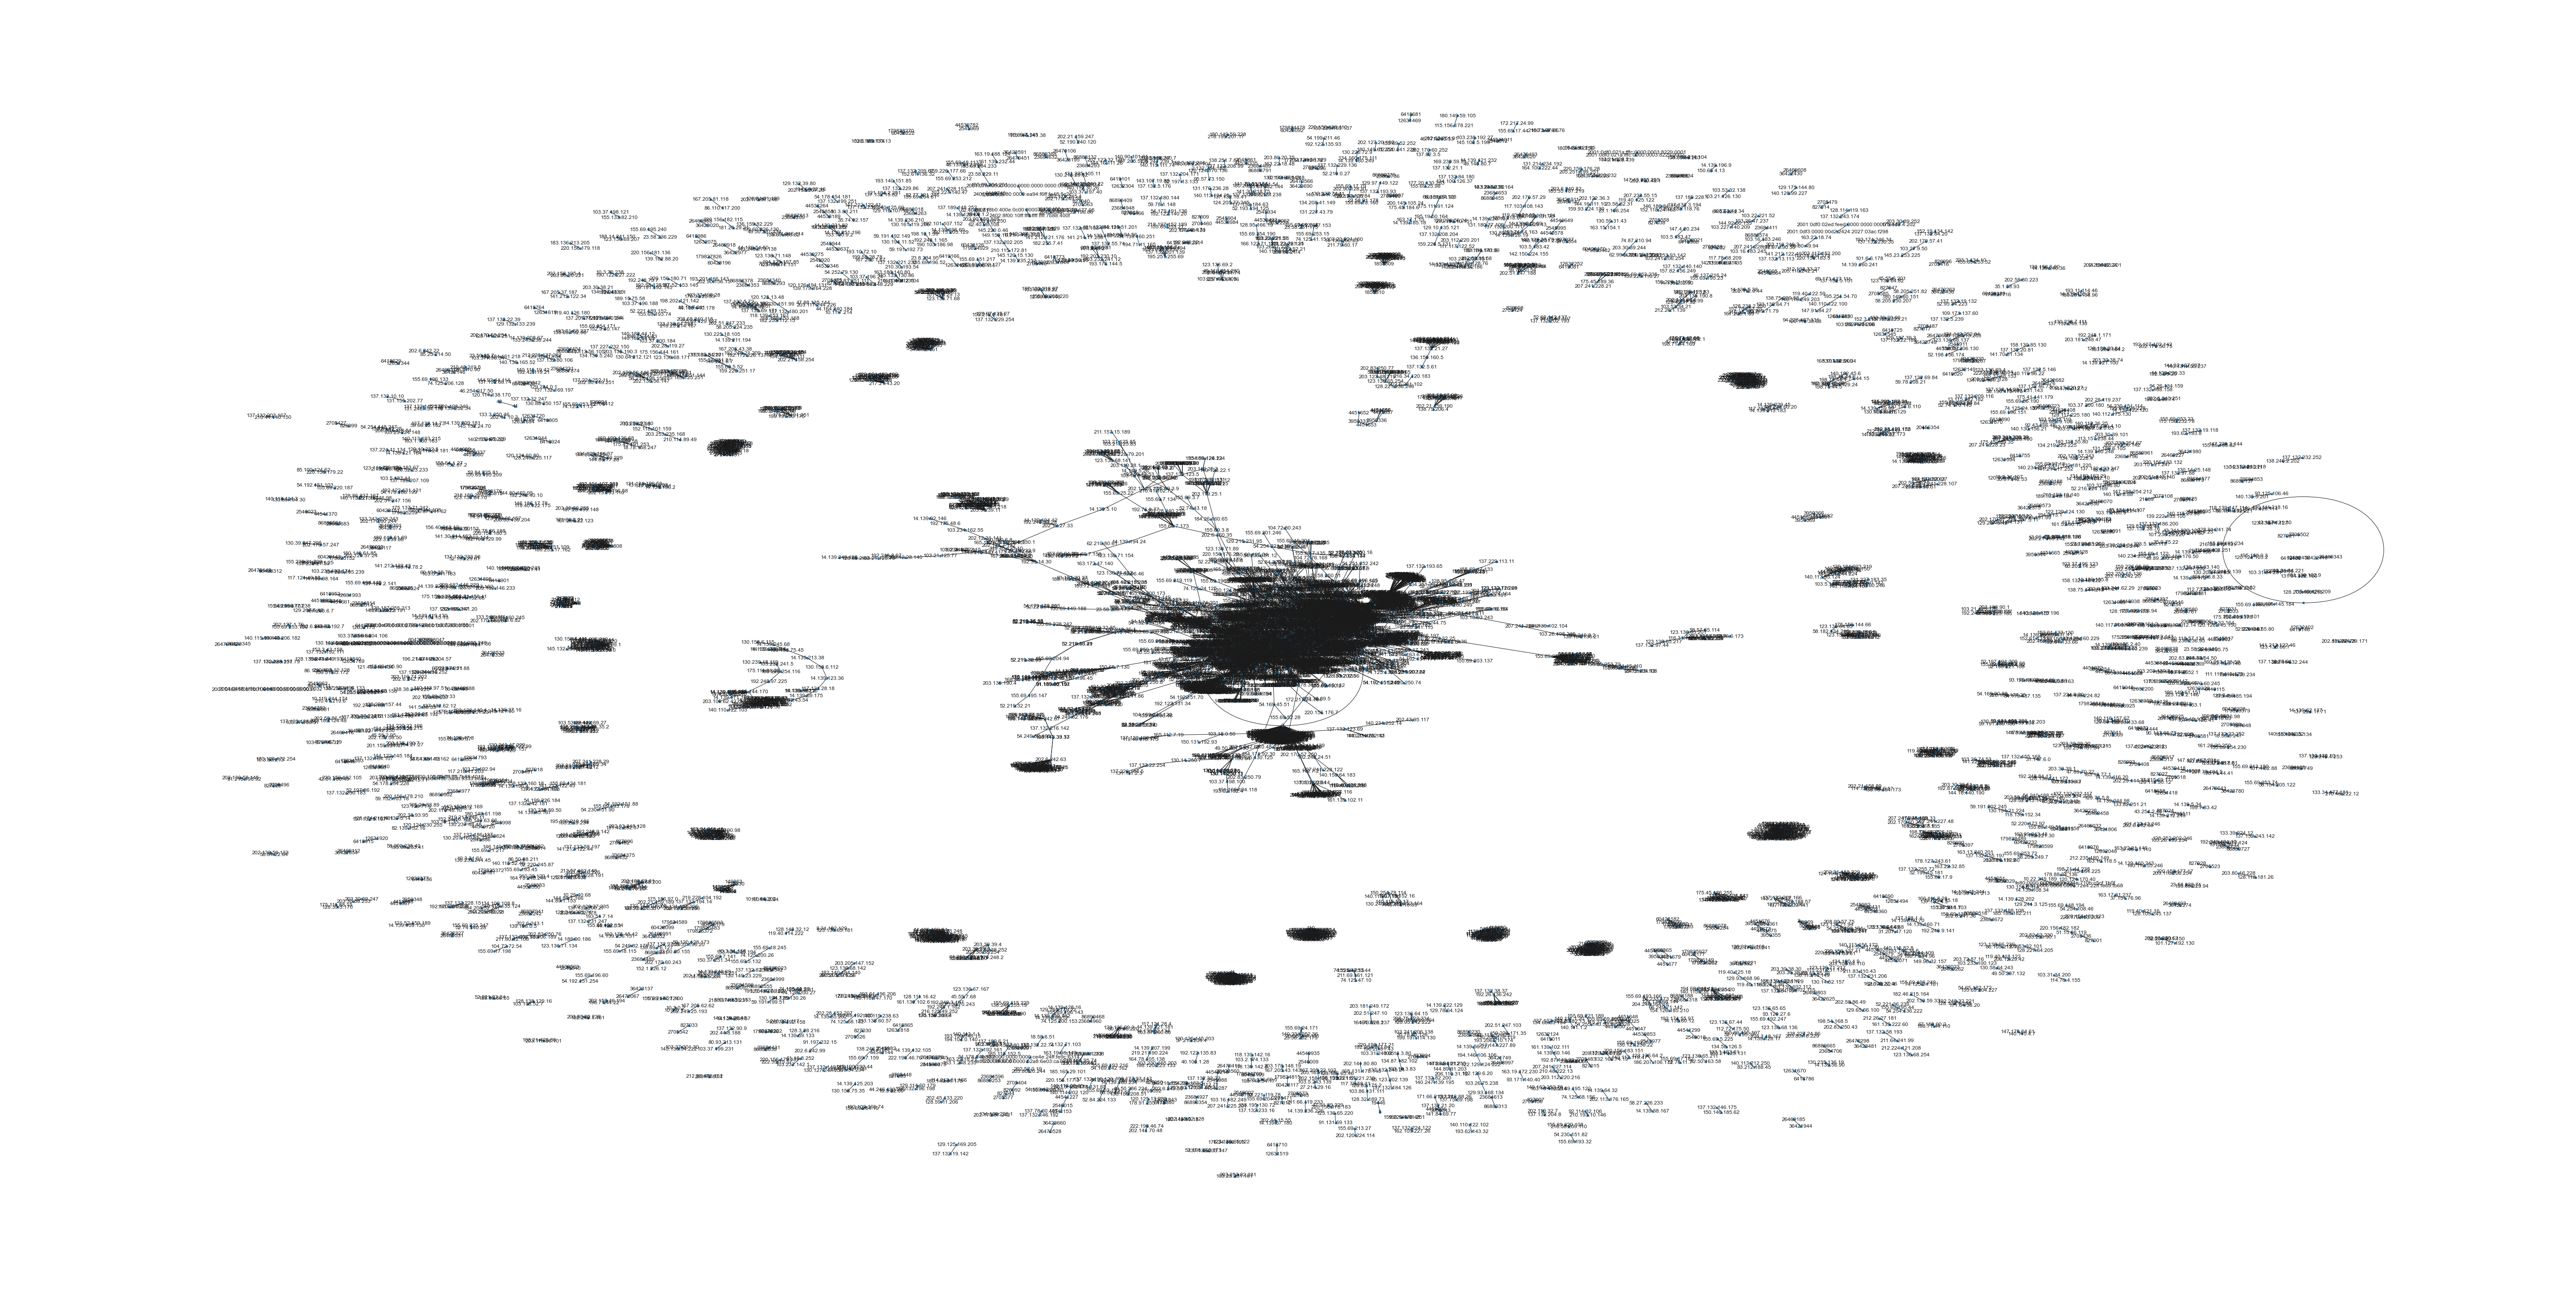

In [38]:
graph = nx.from_pandas_edgelist(src_dst_df, 'src_IP', 'dst_IP')

plt.figure(5, figsize=(80,40))

nx.draw(graph, with_labels=True, node_size=20)

plt.show()